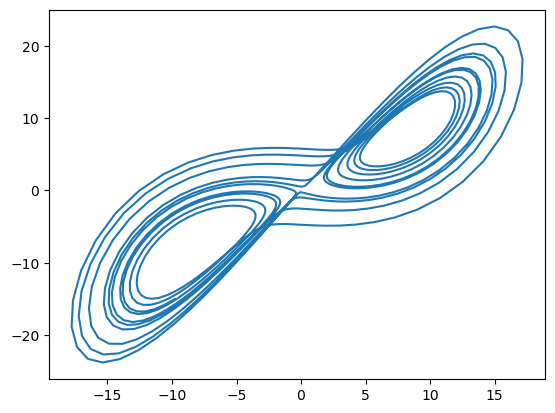

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz

## Load and simulate an attractor
attractor = Lorenz()
sol = attractor.make_trajectory(1000, resample=True, noise=0.00)
sol += np.random.random(sol.shape) * 0.0
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])
# sol = sol[::10]

In [39]:
# let's start with that and then consider other options
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


# from kennel et al.: "It is sufficient to consider only nearest neighbors (r=l)
# and interrogate every point on the orbit (n =1,2, . . . , N)
# to establish how many of the Xnearest neighbors are false.
# We record the results of the computations as the proportion of all orbit points
# which have a false nearest neighbor."
def false_neighbors(true, embedding, r=1, atol=2, rtol=10, metric="euclidean"):
    """

    the false neighbors algorithm:
    a false neighbor is defined as a point in an embedding that is near in the embedding space
    but not in the true space. It is usually used in the context of picking delays
    but here because we have ground truth we can actually assess the quality of reconstruction
    rtol (relative tolerance) is the threshold for distances in embedding space relative to true
    atol (absolute tolerance) is the threshold for distances in the embedding space relative to the dimension of the attractor

    true (np.ndarray): float array of shape T x n
    embedding: float array of shape T x d, with d >>n usually
    """
    # scale the data to be standardized
    true = StandardScaler().fit_transform(true)  # scales along feature axis
    embedding = StandardScaler().fit_transform(embedding)

    # calculate pairwise distances in the true space
    true_dists = pairwise_distances(true, metric=metric)  # TxT matrix
    embedding_dists = pairwise_distances(embedding, metric=metric)  # TxT
    # calculate the r nearest neighbors in the true space to each point
    neighbors = np.argsort(true_dists, axis=0)[
        1 : r + 1
    ]  # T x r, ignoring the first point as it's 0
    # calculate the variance of the true space
    R_a = np.var(true, axis=0).mean()

    # let's vectorize this bad boy straight up
    # need to change the indexing of true_dists here
    true_dists_nn = true_dists[neighbors, np.arange(true.shape[0])]
    embed_dists_nn = embedding_dists[neighbors, np.arange(true.shape[0])]

    ratio = embed_dists_nn / true_dists_nn

    frac_false_rel = np.mean(ratio > rtol)

    ratio_abs = embed_dists_nn / R_a
    frac_false_abs = np.mean(ratio_abs > atol)

    return frac_false_rel, frac_false_abs

In [40]:
from sklearn.neighbors import NearestNeighbors


def neighbors_comparison(true, embedded, n_neighbors=5):
    # nearest neighbors in the original space
    nn_orig = NearestNeighbors(n_neighbors=n_neighbors).fit(true)
    distances_orig, indices_orig = nn_orig.kneighbors(true)

    # nearest neighbors in the embedded space
    nn_embed = NearestNeighbors(n_neighbors=n_neighbors).fit(embedded)
    distances_embed, indices_embed = nn_embed.kneighbors(embedded)

    # compare neighborhoods
    jaccard_indices = [
        len(set(indices_orig[i]).intersection(indices_embed[i])) / n_neighbors
        for i in range(len(true))
    ]

    # Compare distance correlations
    correlation_coefficients = [
        np.corrcoef(distances_orig[i], distances_embed[i])[0, 1]
        for i in range(len(true))
    ]

    return np.mean(jaccard_indices), np.mean(correlation_coefficients)

In [41]:
x = sol[:, 0]
n_delays = 1
H = np.vstack([x[i : -n_delays + i] for i in range(n_delays)]).T
true = sol[n_delays:]
true.shape, H.shape

((9999, 3), (9999, 1))

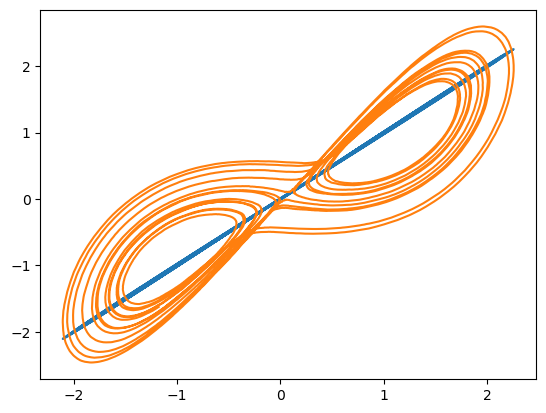

In [27]:
# do an svd on H
U, S, Vh = np.linalg.svd(H.T)
H = StandardScaler().fit_transform(H)

s = StandardScaler().fit_transform(sol)
plt.plot(H[:, 0], H[:, 1])
plt.plot(s[:, 0], s[:, 1])

1
2
3
4
5
6
7
8
9
10


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


Text(0, 0.5, 'correlation between distances in spaces')

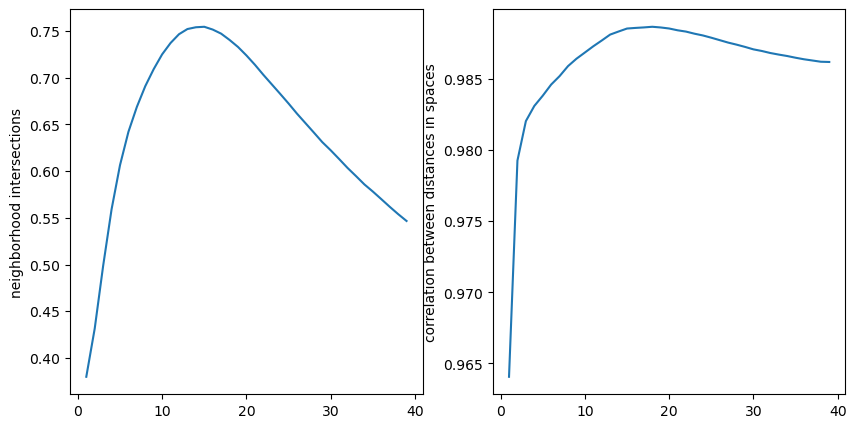

In [60]:
all_neighbs, all_corrs = [], []
nd = np.arange(1, 40)
x = sol[:, 0]
for n_delays in nd:
    print(n_delays)
    H = np.vstack([x[i : -n_delays + i] for i in range(n_delays)]).T
    true = sol[n_delays:]

    neighb, corr = neighbors_comparison(true, H, n_neighbors=50)
    # maybe n_neighbors is a function of the dataset size?
    all_neighbs.append(neighb)
    all_corrs.append(corr)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(nd, all_neighbs)
ax[0].set_ylabel("neighborhood intersections")
ax[1].plot(nd, all_corrs)
ax[1].set_ylabel("correlation between distances in spaces")

In [61]:
np.argmax(all_neighbs), np.argmax(all_corrs)

(14, 17)